# **EDA for HIV forecasting project**

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
%matplotlib inline

## Loading Data

In [177]:
#load Amfar opioid and HIV data
opiod_df = pd.read_table('data/tmp/countydata.tsv',header=0)
opiod_df['county_code'] = opiod_df.STATEFP*1000 + opiod_df.COUNTYFP # build a county code column
opiod_df['county_code'] = opiod_df.county_code.astype(int)

#make changes to the amfar dataframe
#convert from long to wide format
opiod_df_wide = opiod_df.pivot_table(values='VALUE', index=['county_code',
                                                            'COUNTY',
                                                            'STATEABBREVIATION',
                                                            'YEAR'], columns='INDICATOR').reset_index()
opiod_df_wide.drop(['CDC_consult', 'vulnerable_rank'], axis=1, inplace=True) # drop unnecessary columns
opiod_df_wide = opiod_df_wide[opiod_df_wide.YEAR >= 2008] # subset for years that have hiv data
opiod_df_wide[['HIVdiagnoses', 
               'HIVincidence', 
               'HIVprevalence', 
               'HIVprevalence', 
               'PLHIV', 
               'drugdeathrate', 
               'drugdeaths']] = opiod_df_wide[['HIVdiagnoses', 
                                               'HIVincidence', 
                                               'HIVprevalence', 
                                               'HIVprevalence',
                                               'PLHIV',
                                               'drugdeathrate', 
                                               'drugdeaths']].fillna(0) #fill NaNs for suppressed data with zeroes

#subset data to 2015
opiod_df_15 = opiod_df_wide[opiod_df_wide.YEAR == 2015]
opiod_df_15.drop(['num_SSPs', 'bup_phys', 'drugdep', 'pctunmetneed', 'nonmedpain'], axis=1, inplace=True) #drop columns having no 2015 data



/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [178]:
#subset opioid related data from one year only
#number of needle exchange programs
opiod_df_wide_17 = opiod_df_wide[opiod_df_wide.YEAR == 2017]
df_num_SSP = opiod_df_wide_17[['num_SSPs', 'county_code']]

#number of doctors licensed to rx Buprenorphine
df_bup_phys = opiod_df_wide_17[['bup_phys', 'county_code']]

#percent with drug dependency
opiod_df_wide_16 = opiod_df_wide[opiod_df_wide.YEAR == 2016]
df_drugdep = opiod_df_wide_16[['drugdep', 'county_code']]

#percent unmet drug treatment need
df_pctunmetneed = opiod_df_wide_16[['pctunmetneed', 'county_code']]

#percent taken pain meds for nonmedical use
df_nonmedpain = opiod_df_wide_16[['nonmedpain', 'county_code']]

#merge opioid related data back to the 2015 dataframe
opiod_df_15 = opiod_df_15.merge(df_num_SSP, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_bup_phys, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_drugdep, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_pctunmetneed, on='county_code')
opiod_df_15 = opiod_df_15.merge(df_nonmedpain, on='county_code')

In [179]:
#load Men who have sex with men (MSM) estimate data
msm_df = pd.read_csv("data/US MSM Estimates Data 2013.csv")    #load the data
msm_df['county_code'] = msm_df.STATEFP*1000 + msm_df.COUNTYFP  # build a county code column
msm_df['county_code'] = msm_df.county_code.astype(int)
msm_df['%msm12month'] = 100 * (msm_df.MSM12MTH / msm_df.ADULTMEN) # build a %MSM within last 12 months column
msm_df['%msm5yr'] = 100 * (msm_df.MSM5YEAR / msm_df.ADULTMEN)     # build a %MSM within last 5years column
msm_df.drop(['REGCODE', 
             'DIVCODE', 
             'STATEFP', 
             'COUNTYFP', 
             'CSACODE', 
             'CBSACODE', 
             'METDCODE', 
             'METMICSA', 
             'CENTOUTL'], axis=1, inplace=True) #drop all unneeded columns

In [180]:
#Load American Community Survey 5yr data from 2014
#unemplyment data
df_employment = pd.read_csv("data/ACS_14_5YR_employment/ACS_14_5YR_S2301_with_ann.csv", encoding = "ISO-8859-1", skiprows=1)
df_employment = df_employment[['Id2', 'Unemployment rate; Estimate; Population 16 years and over']]
df_employment.columns = ['county_code', 'unemployment_rate']

#poverty data
df_poverty = pd.read_csv("data/ACS_14_5YR_poverty/ACS_14_5YR_S1701_with_ann.csv", encoding = "ISO-8859-1", skiprows=1)
df_poverty = df_poverty[['Id2', 'Percent below poverty level; Estimate; Population for whom poverty status is determined']]
df_poverty.columns = ['county_code', 'poverty_rate']

#income data
df_income = pd.read_csv("data/ACS_14_5YR_income/ACS_14_5YR_S1901_with_ann.csv", encoding = "ISO-8859-1", skiprows=1)
df_income = df_income[['Id2', 'Households; Estimate; Total']]
df_income.columns = ['county_code', 'household_income']

#demographic data
df_demo = pd.read_csv("data/ACS_14_5YR_age_sex_race/ACS_14_5YR_DP05_with_ann.csv", encoding = "ISO-8859-1", skiprows=1)
df_demo = df_demo[['Id2',  'Percent; SEX AND AGE - Total population - Male', 'Percent; SEX AND AGE - 20 to 24 years', 'Percent; SEX AND AGE - 25 to 34 years', 'Percent; SEX AND AGE - 35 to 44 years', 'Percent; RACE - Race alone or in combination with one or more other races - Total population - White', 'Percent; RACE - Race alone or in combination with one or more other races - Total population - Black or African American', 'Percent; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race)']]
df_demo.columns = ['county_code', 'perc_male', 'perc_20_24', 'perc_25_34', 'perc_35_44', 'perc_white', 'perc_black', 'perc_hisp']
df_demo['perc_20_44'] = df_demo.perc_20_24 + df_demo.perc_25_34 + df_demo.perc_35_44 # new column for percentage of 20-44 year olds
df_demo.drop(['perc_20_24', 'perc_25_34', 'perc_35_44'], axis=1, inplace=True) #drop old columns

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (13,14,19,20,193,194,265,266) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Merging data

In [181]:
#merge hiv/opioid data w MSM data
df_main = opiod_df_15.merge(msm_df, on='county_code')

#merge with ACS data
df_main = df_main.merge(df_employment, on='county_code')
df_main = df_main.merge(df_poverty, on='county_code')
df_main = df_main.merge(df_income, on='county_code')
df_main = df_main.merge(df_demo, on='county_code')

In [182]:
df_main.head()

,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,%msm12month,%msm5yr,unemployment_rate,poverty_rate,household_income,perc_male,perc_white,perc_black,perc_hisp,perc_20_44
0,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,0.0,...,1.715611,2.648120,8.5,12.8,20304,48.6,79.2,19.1,2.5,32.4
1,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,0.0,...,1.326659,2.049509,8.6,13.8,73058,48.8,88.2,10.0,4.5,29.4
2,1005,Barbour County,AL,2015,0.0,0.0,0.0,436.0,1.0,0.0,...,0.708913,1.097951,14.2,24.1,9145,53.7,48.7,47.3,4.7,33.6
3,1007,Bibb County,AL,2015,0.0,0.0,0.0,191.9,0.0,0.0,...,1.251578,1.935212,10.9,17.0,7078,53.9,77.9,22.0,2.0,33.7
4,1009,Blount County,AL,2015,0.0,5.0,10.4,95.4,1.0,0.0,...,2.812617,4.342943,9.3,17.3,20934,49.6,96.8,2.1,8.5,30.2


## Exploring the data

### **Finding good predictors of our target (HIV incidence)**

We will start out with something that should be a good predictor of HIV incidence (number of new diagnoses per 100,000 people).  We will first look at HIV prevalence in a community which are the number of HIV+ inddividuals per 100,000.


Text(0,0.5,'HIV prevalence')

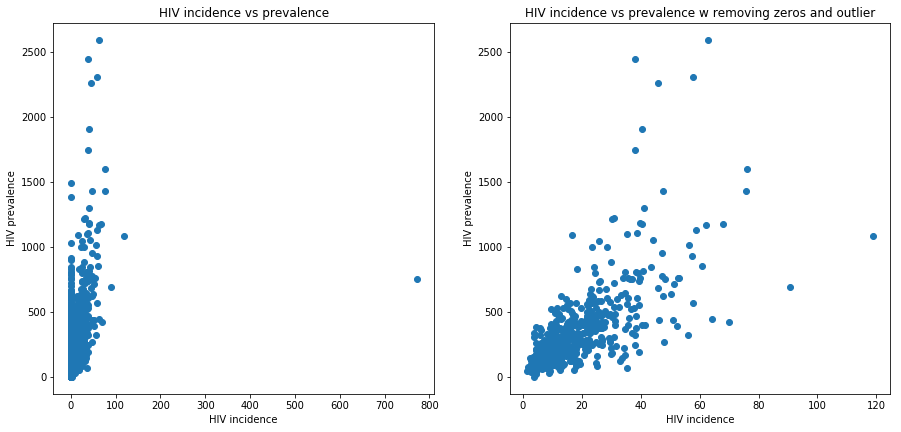

In [183]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.scatter(df_main.HIVincidence, df_main.HIVprevalence)
ax1.set_title('HIV incidence vs prevalence')
ax1.set_xlabel('HIV incidence')
ax1.set_ylabel('HIV prevalence')

df_main_no_zero_outlier = df_main[((df_main.HIVincidence > 0) & (df_main.HIVincidence < 130))]
ax1 = fig.add_subplot(222)
ax1.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.HIVprevalence)
ax1.set_title('HIV incidence vs prevalence w removing zeros and outlier')
ax1.set_xlabel('HIV incidence')
ax1.set_ylabel('HIV prevalence')

The prevalence of HIV in a community should be a good predictor of HIV incidence.  HIV incidence data at 0 and one extreme outlier were removed to better determine associations with HIV incidence.

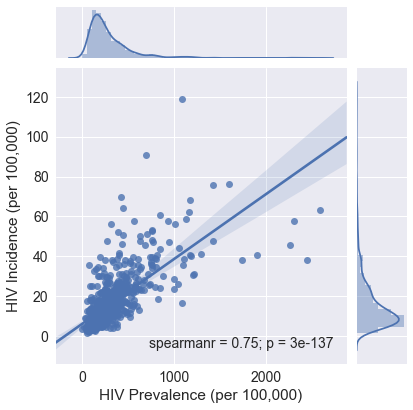

In [262]:
sns.jointplot(x='HIVprevalence', y='HIVincidence', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr)
plt.xlabel('HIV Prevalence (per 100,000)')
plt.ylabel('HIV Incidence (per 100,000)')
plt.savefig('images/HIVincid_vs_prev.png', bbox_inches='tight');

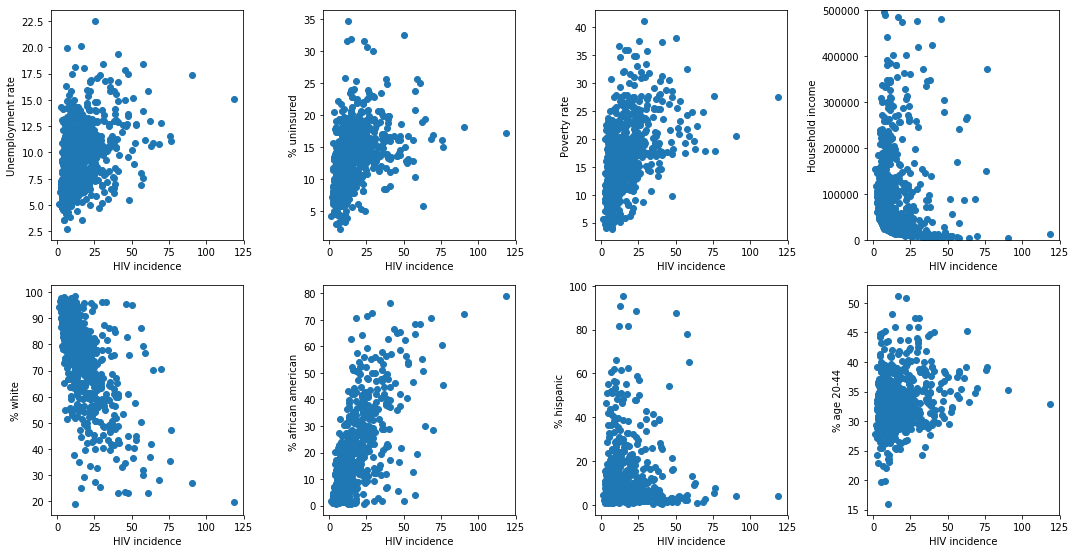

In [185]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(441)
ax1.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.unemployment_rate)
# ax1.set_xlim(xmin=0, xmax=130)
# ax1.set_ylim(ymin=0, ymax=2500)
#ax1.set_title('HIV incidence vs prevalence')
ax1.set_xlabel('HIV incidence')
ax1.set_ylabel('Unemployment rate')

ax2 = fig.add_subplot(442)
ax2.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.pctunins)
# ax2.set_xlim(xmin=0, xmax=130)
# ax2.set_ylim(ymin=0, ymax=60)
#ax2.set_title('HIV incidence vs % uninsured')
ax2.set_xlabel('HIV incidence')
ax2.set_ylabel('% uninsured')

ax3 = fig.add_subplot(443)
ax3.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.poverty_rate)
# ax3.set_xlim(xmin=0, xmax=130)
# ax3.set_ylim(ymin=0, ymax=150)
#ax3.set_title('HIV incidence vs Drug death rate')
ax3.set_xlabel('HIV incidence')
ax3.set_ylabel('Poverty rate')


ax4 = fig.add_subplot(444)
ax4.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.household_income)
# ax4.set_xlim(xmin=0, xmax=130)
ax4.set_ylim(ymin=0, ymax=500000)
#ax4.set_title('HIV incidence vs Mental Health Facilities')
ax4.set_xlabel('HIV incidence')
ax4.set_ylabel('Household income')

ax5 = fig.add_subplot(445)
ax5.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.perc_white)
# ax5.set_xlim(xmin=0, xmax=130)
# ax5.set_ylim(ymin=70, ymax=110)
#ax5.set_title('HIV incidence vs % Unmet drug treatment need')
ax5.set_xlabel('HIV incidence')
ax5.set_ylabel('% white')

ax6 = fig.add_subplot(446)
ax6.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.perc_black)
# ax6.set_xlim(xmin=0, xmax=130)
# ax6.set_ylim(ymin=1.5, ymax=4.5)
#ax6.set_title('HIV incidence vs % % Reporting drug dependency')
ax6.set_xlabel('HIV incidence')
ax6.set_ylabel('% african american ')

ax7 = fig.add_subplot(447)
ax7.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.perc_hisp)
#ax7.set_xlim(xmin=0, xmax=130)
#ax1.set_ylim(ymin=1.5, ymax=4.5)
#ax7.set_title('HIV incidence vs Physicians Licensed to Administer Buprenorphine')
ax7.set_xlabel('HIV incidence')
ax7.set_ylabel('% hispanic')

ax8 = fig.add_subplot(448)
ax8.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.perc_20_44)
#ax8.set_xlim(xmin=0, xmax=130)
#ax1.set_ylim(ymin=1.5, ymax=4.5)
#ax8.set_title('HIV incidence vs % Reporting non-med pain reliever use')
ax8.set_xlabel('HIV incidence')
ax8.set_ylabel('% age 20-44')

plt.tight_layout()

Predictably, race has a very strong association with the HIV incidence in a community.  Here we see that the % of white residents is negatively correlated while the % of black residents is positively correlated.

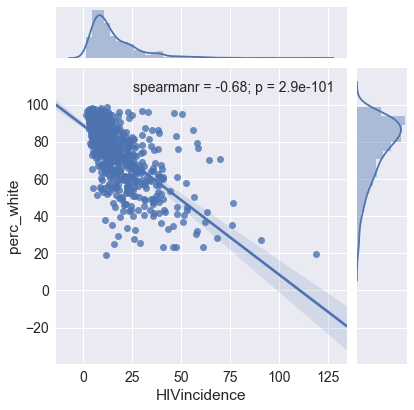

In [260]:
sns.jointplot(x='HIVincidence', y='perc_white', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr)
;

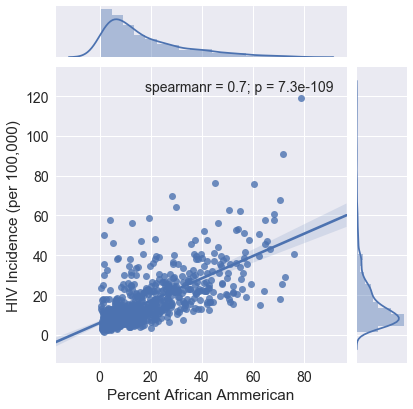

In [268]:
sns.jointplot(x='perc_black', y='HIVincidence', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr)
plt.xlabel('Percent African Ammerican')
plt.ylabel('HIV Incidence (per 100,000)')
plt.savefig('images/HIVincid_vs_perc_AA', bbox_inches='tight');

Some of the indicators of poverty also look to be associated with HIV incidence but perhaps not as strongly.  The household income looks particularly promising but will need to be log10 transformed first.

In [187]:
df_main_no_zero_outlier['log_household_income'] = np.log10(df_main_no_zero_outlier.household_income)

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


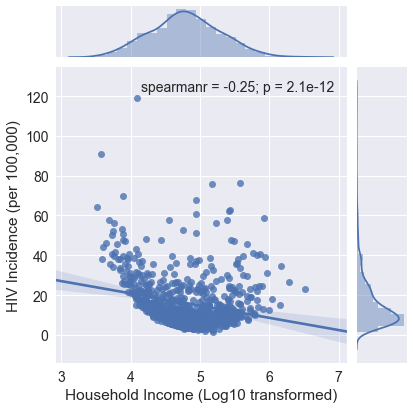

In [266]:
sns.jointplot(x='log_household_income', y='HIVincidence', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr)
plt.xlabel('Household Income (Log10 transformed)')
plt.ylabel('HIV Incidence (per 100,000)')
plt.savefig('images/HIVincid_vs_log_house_income', bbox_inches='tight');

Not as good as I was hoping. Let's look at some more.

In [ ]:
sns.jointplot(x='HIVincidence', y='unemployment_rate', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr)
;

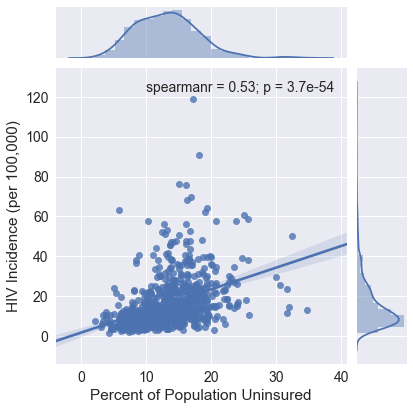

In [267]:
sns.jointplot(x='pctunins', y='HIVincidence', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr)
plt.xlabel('Percent of Population Uninsured')
plt.ylabel('HIV Incidence (per 100,000)')
plt.savefig('images/HIVincid_vs_log_house_income', bbox_inches='tight');

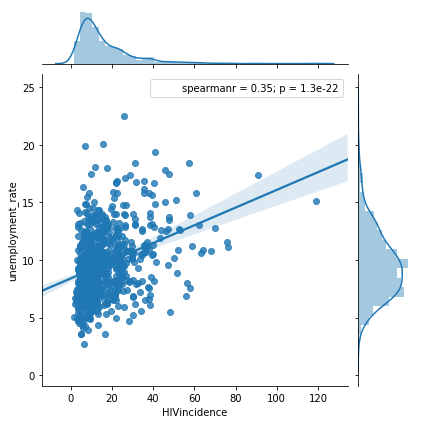

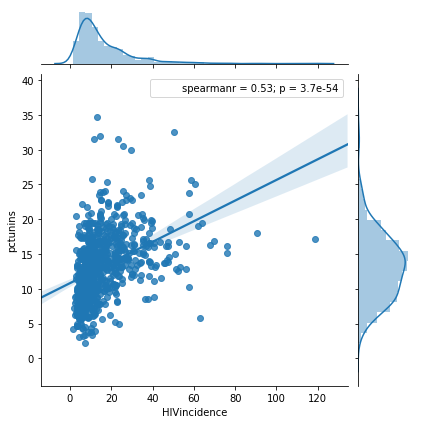

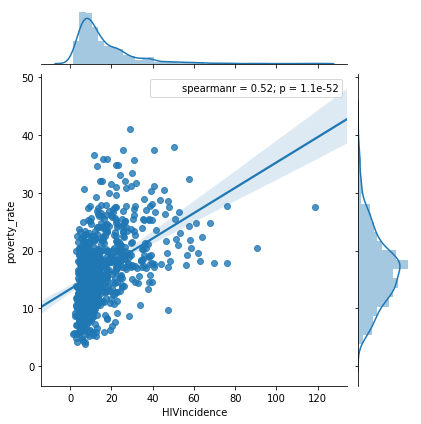

In [189]:
sns.jointplot(x='HIVincidence', y='poverty_rate', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);

Age may also play a small role.

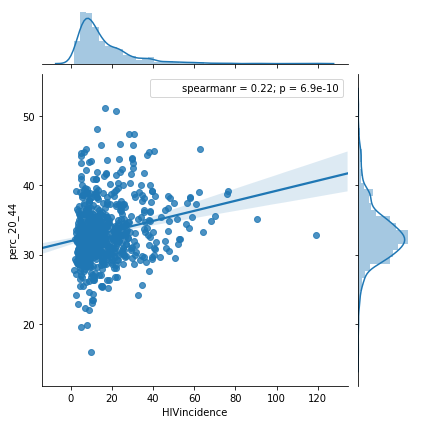

In [190]:
sns.jointplot(x='HIVincidence', y='perc_20_44', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);

HIV is also still a problem in the MSM community.  I hypothesize that the number or % of MSM in a community is a good predictor of HIV incidence

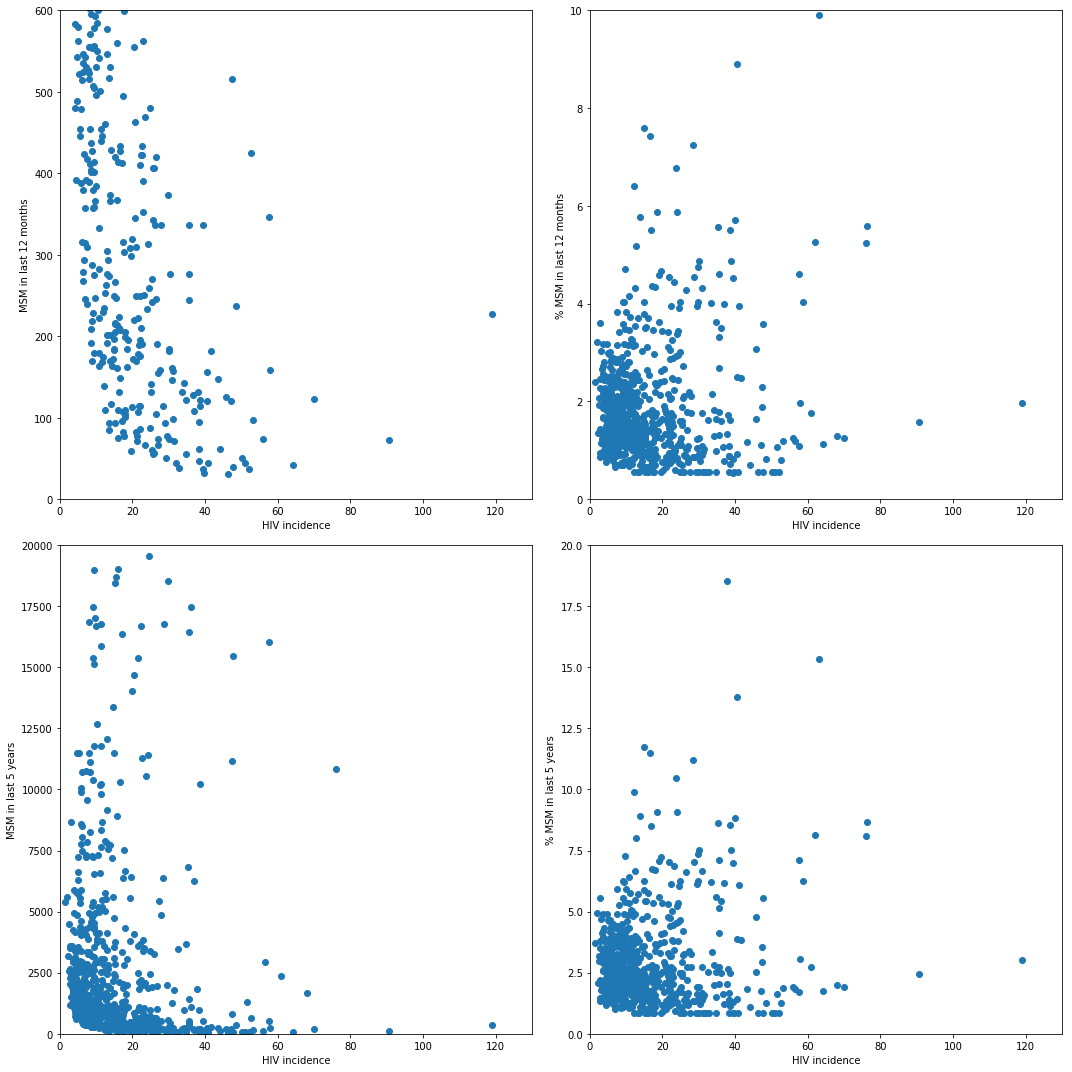

In [191]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(221)
ax1.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.MSM12MTH)
ax1.set_xlim(xmin=0, xmax=130)
ax1.set_ylim(ymin=0, ymax=600)
#ax1.set_title('HIV incidence vs prevalence')
ax1.set_xlabel('HIV incidence')
ax1.set_ylabel('MSM in last 12 months')

ax2 = fig.add_subplot(222)
ax2.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier['%msm12month'])
ax2.set_xlim(xmin=0, xmax=130)
ax2.set_ylim(ymin=0, ymax=10)
#ax2.set_title('HIV incidence vs prevalence')
ax2.set_xlabel('HIV incidence')
ax2.set_ylabel('% MSM in last 12 months')

ax3 = fig.add_subplot(223)
ax3.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.MSM5YEAR)
ax3.set_xlim(xmin=0, xmax=130)
ax3.set_ylim(ymin=0, ymax=20000)
#ax3.set_title('HIV incidence vs prevalence')
ax3.set_xlabel('HIV incidence')
ax3.set_ylabel('MSM in last 5 years')

ax4 = fig.add_subplot(224)
ax4.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier['%msm5yr'])
ax4.set_xlim(xmin=0, xmax=130)
ax4.set_ylim(ymin=0, ymax=20)
#ax4.set_title('HIV incidence vs prevalence')
ax4.set_xlabel('HIV incidence')
ax4.set_ylabel('% MSM in last 5 years')

plt.tight_layout()

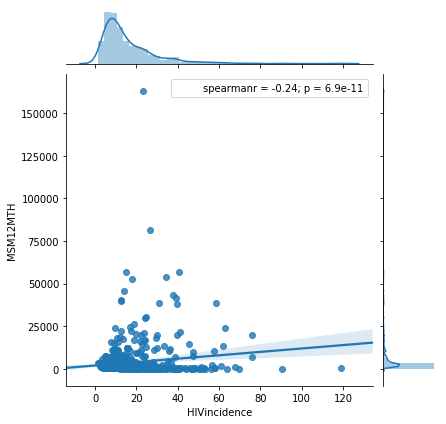

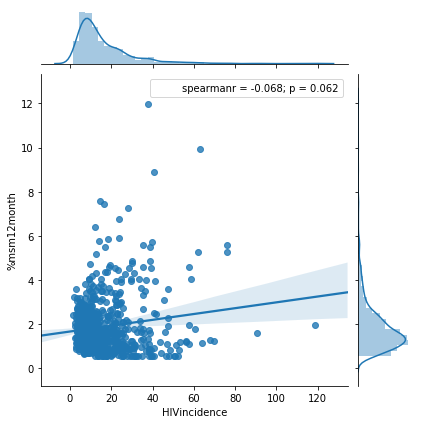

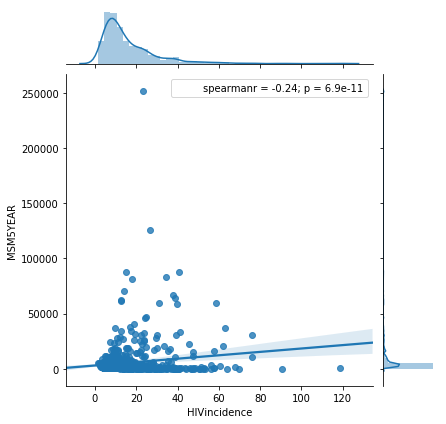

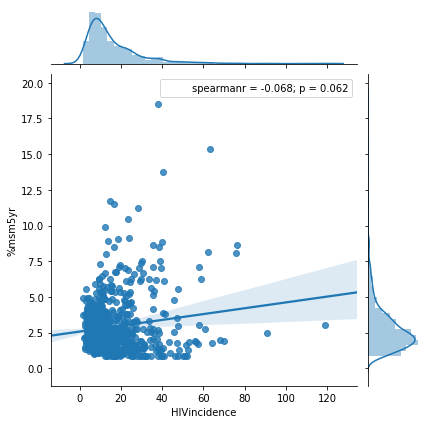

In [192]:
sns.jointplot(x='HIVincidence', y='MSM12MTH', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);
sns.jointplot(x='HIVincidence', y='%msm12month', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);
sns.jointplot(x='HIVincidence', y='MSM5YEAR', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);
sns.jointplot(x='HIVincidence', y='%msm5yr', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);

Contrary to what I predicted, MSM levels were not a good predictor of HIV incidence.

We now have some idea about how ecomomic and demographic factors are associated with HIV incidence.  The opioid crisis is also impacting HIV infections in some communities.  Let's take a look at some of the indicators of opioid abuse and their association with HIV incidence.

There are bunch of features relating to the number of drug or mental health treatment facilities in an area.  These are likely to be coliniear

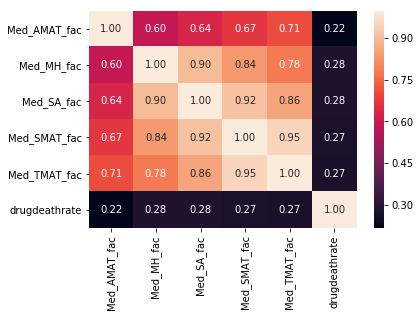

In [193]:
sns.heatmap(df_main_no_zero_outlier[['Med_AMAT_fac', 
                                    'Med_MH_fac', 
                                    'Med_SA_fac', 
                                    'Med_SMAT_fac',
                                    'Med_TMAT_fac',
                                    'drugdeathrate']].corr(), annot=True, fmt=".2f")

They are highly correlated and we can probably just test one for an association with HIV incidence.

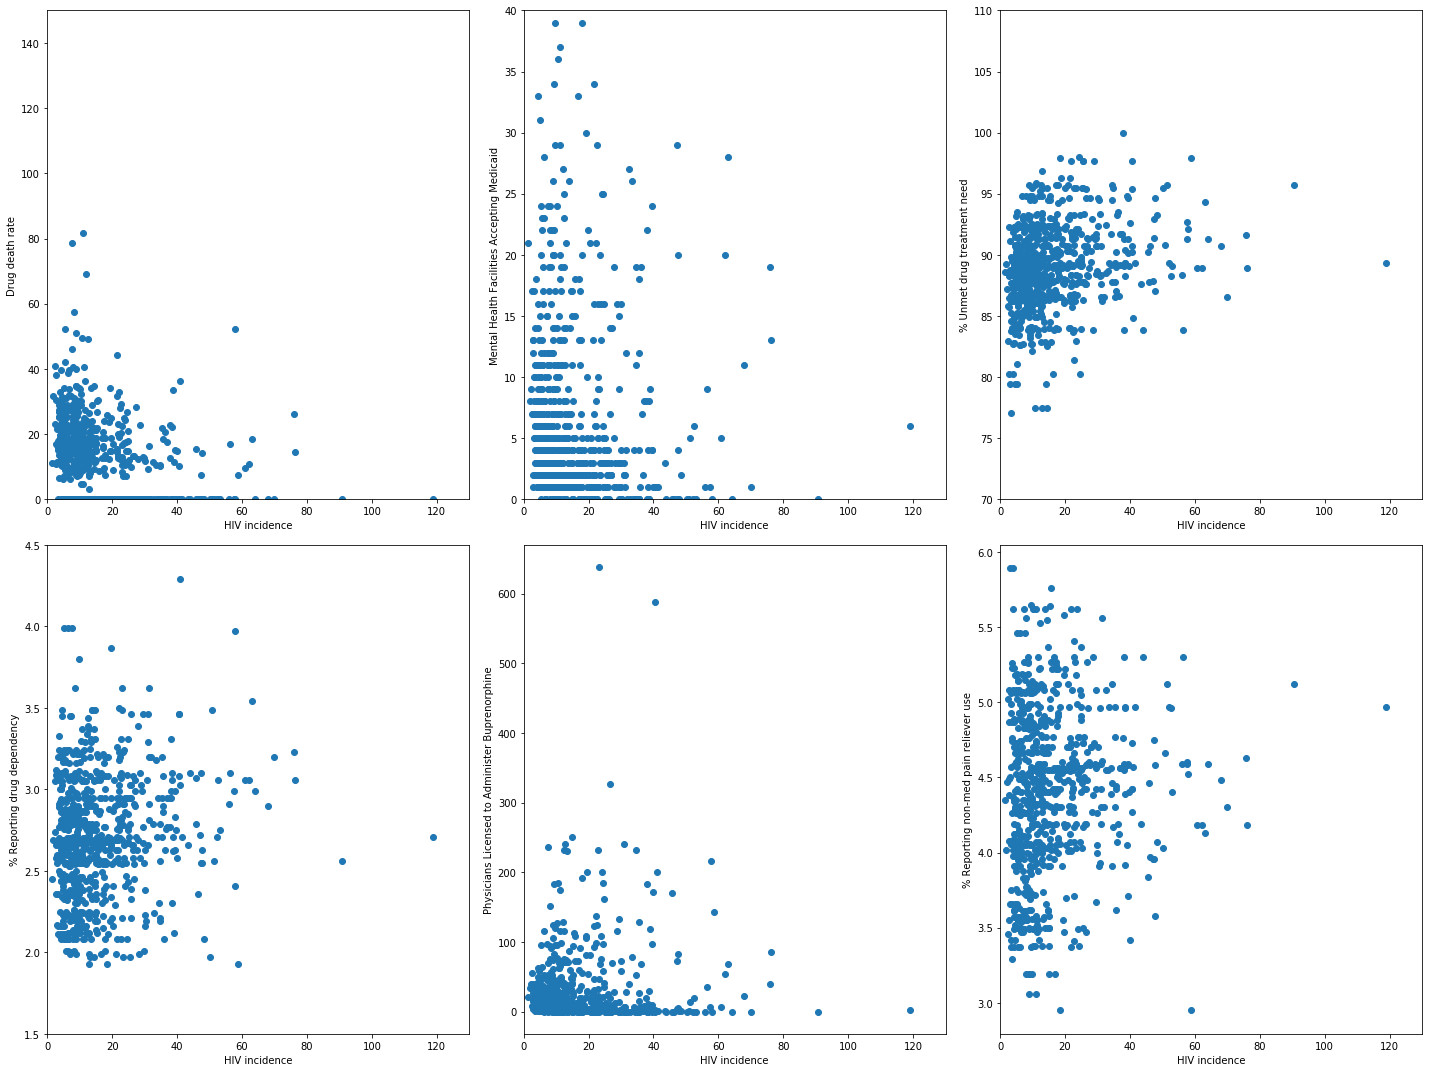

In [194]:
fig = plt.figure(figsize=(20,15))

ax3 = fig.add_subplot(231)
ax3.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.drugdeathrate)
ax3.set_xlim(xmin=0, xmax=130)
ax3.set_ylim(ymin=0, ymax=150)
#ax3.set_title('HIV incidence vs Drug death rate')
ax3.set_xlabel('HIV incidence')
ax3.set_ylabel('Drug death rate')

ax4 = fig.add_subplot(232)
ax4.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.Med_MH_fac)
ax4.set_xlim(xmin=0, xmax=130)
ax4.set_ylim(ymin=0, ymax=40)
#ax4.set_title('HIV incidence vs Mental Health Facilities')
ax4.set_xlabel('HIV incidence')
ax4.set_ylabel('Mental Health Facilities Accepting Medicaid')

ax5 = fig.add_subplot(233)
ax5.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.pctunmetneed)
ax5.set_xlim(xmin=0, xmax=130)
ax5.set_ylim(ymin=70, ymax=110)
#ax5.set_title('HIV incidence vs % Unmet drug treatment need')
ax5.set_xlabel('HIV incidence')
ax5.set_ylabel('% Unmet drug treatment need')

ax6 = fig.add_subplot(234)
ax6.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.drugdep)
ax6.set_xlim(xmin=0, xmax=130)
ax6.set_ylim(ymin=1.5, ymax=4.5)
#ax6.set_title('HIV incidence vs % % Reporting drug dependency')
ax6.set_xlabel('HIV incidence')
ax6.set_ylabel('% Reporting drug dependency')

ax7 = fig.add_subplot(235)
ax7.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.bup_phys)
ax7.set_xlim(xmin=0, xmax=130)
#ax1.set_ylim(ymin=1.5, ymax=4.5)
#ax7.set_title('HIV incidence vs Physicians Licensed to Administer Buprenorphine')
ax7.set_xlabel('HIV incidence')
ax7.set_ylabel('Physicians Licensed to Administer Buprenorphine')

ax8 = fig.add_subplot(236)
ax8.scatter(df_main_no_zero_outlier.HIVincidence, df_main_no_zero_outlier.nonmedpain)
ax8.set_xlim(xmin=0, xmax=130)
#ax1.set_ylim(ymin=1.5, ymax=4.5)
#ax8.set_title('HIV incidence vs % Reporting non-med pain reliever use')
ax8.set_xlabel('HIV incidence')
ax8.set_ylabel('% Reporting non-med pain reliever use')

plt.tight_layout()

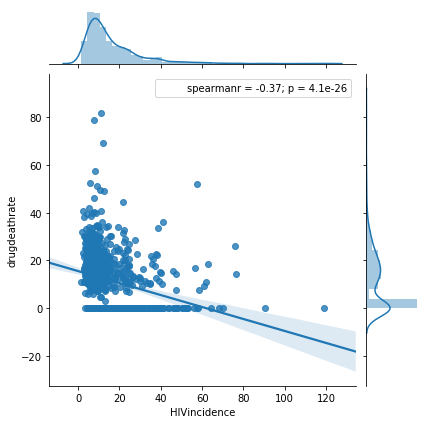

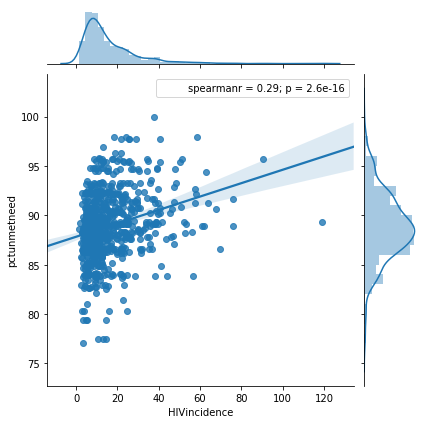

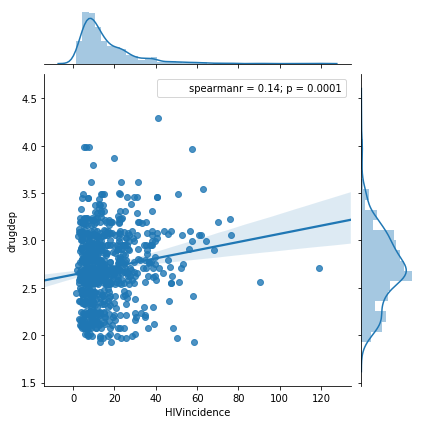

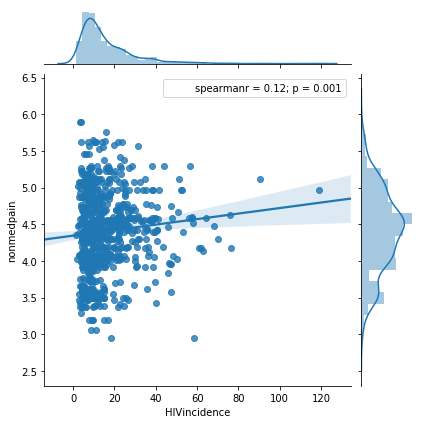

In [195]:
sns.jointplot(x='HIVincidence', y='drugdeathrate', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);
sns.jointplot(x='HIVincidence', y='pctunmetneed', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);
sns.jointplot(x='HIVincidence', y='drugdep', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);
sns.jointplot(x='HIVincidence', y='nonmedpain', data=df_main_no_zero_outlier, kind="reg", stat_func=spearmanr);

These associations are small but they may be important for particular communities

What is the correlation between some of the better predictors that I have looked at?

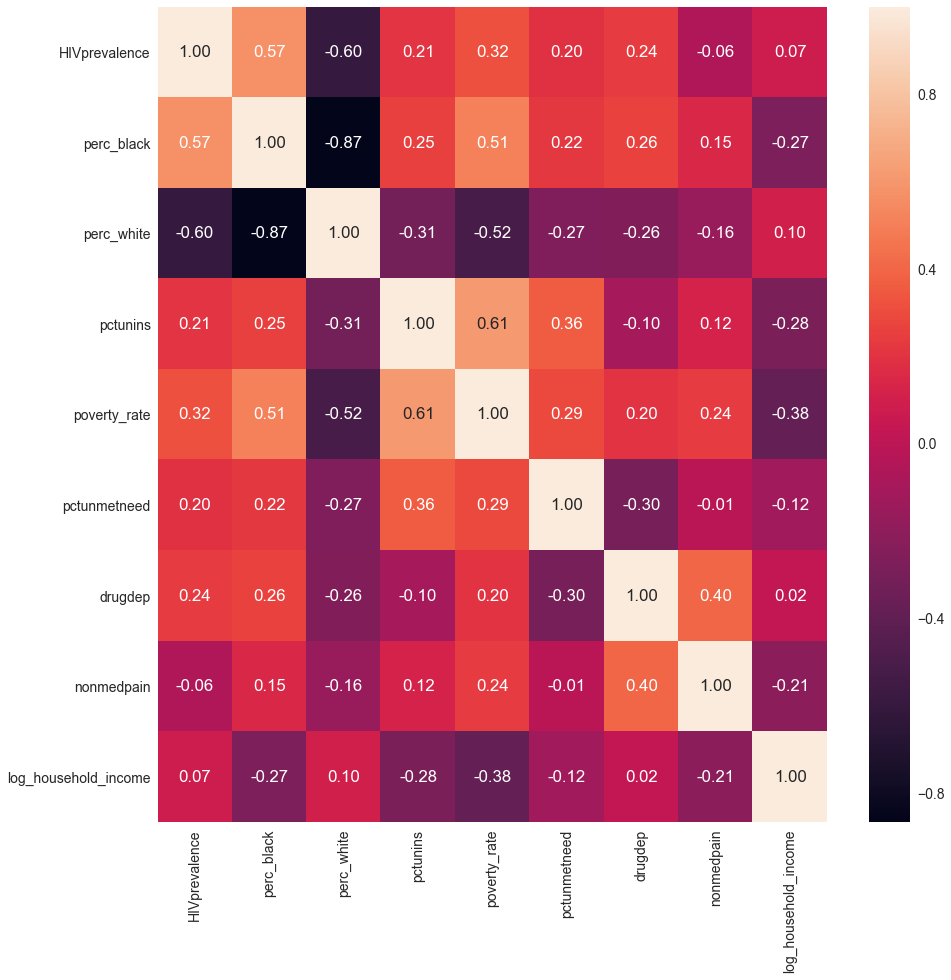

In [256]:
sns.set(font_scale=1.4)
fig = plt.figure(figsize=(15,15))
sns.heatmap(df_main_no_zero_outlier[['HIVprevalence', 
                                    'perc_black', 
                                    'perc_white', 
                                    'pctunins',
                                    'poverty_rate',
                                    'pctunmetneed',
                                    'drugdep', 
                                    'nonmedpain',
                                    'log_household_income']].corr(), annot=True, fmt=".2f")


How does the incidence of HIV differ between different states?

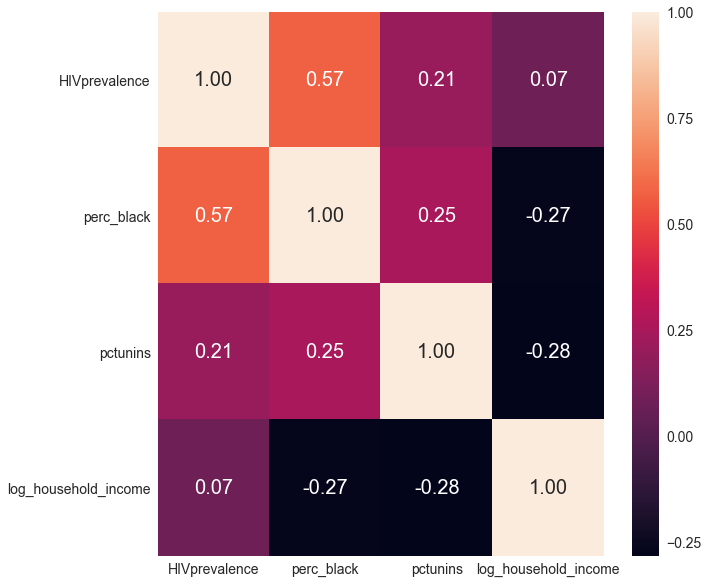

In [255]:
sns.set(font_scale=1.4)
fig = plt.figure(figsize=(10,10))
sns.heatmap(df_main_no_zero_outlier[['HIVprevalence', 
                                    'perc_black',  
                                    'pctunins',
                                     'log_household_income']].corr(), annot=True, fmt=".2f", annot_kws={"size": 20})


Text(0.5,0,'US States')

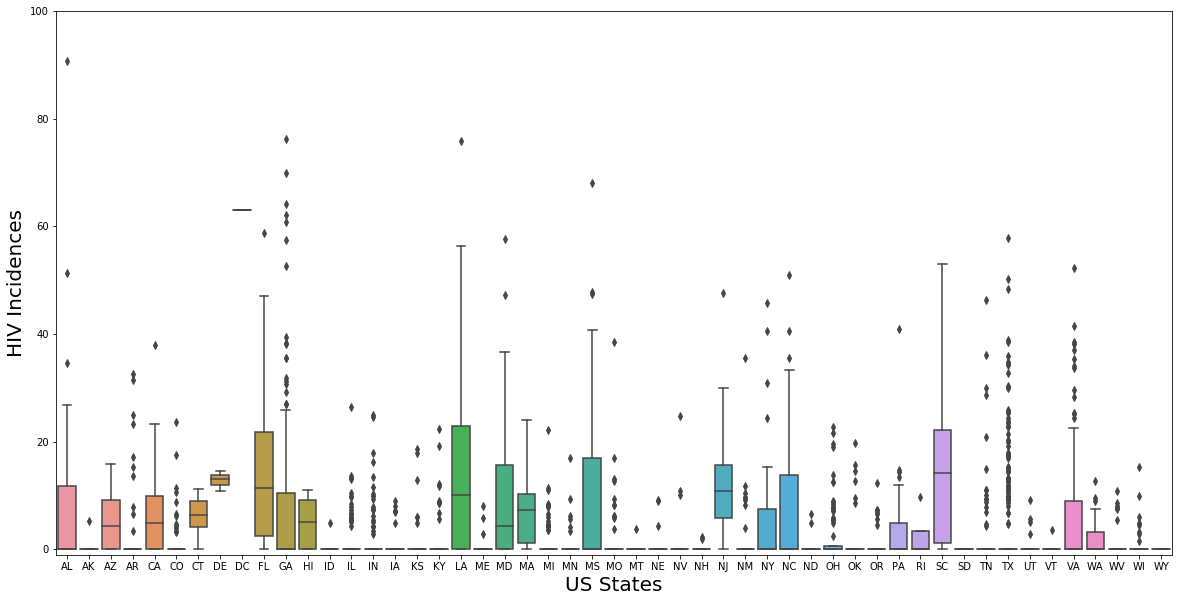

In [197]:
plt.subplots(figsize=(20,10))
sns.boxplot(x="STATEABBREVIATION", y="HIVincidence", data=df_main)
plt.ylim(-1, 100)
plt.ylabel('HIV Incidences', fontsize=20)
plt.xlabel('US States', fontsize=20)

States differ quite a bit.

Let's take a closer look at those communities with incidence less than 4 (these were the supressed data that were converted from Nan to 0)

In [198]:
df_main[df_main.STATEABBREVIATION == 'PR'].shape

(0, 43)

In [199]:
df_main_zeroInc = df_main[df_main.HIVincidence == 0]
df_main_zeroInc.drop(df_main_zeroInc[df_main_zeroInc.STATEABBREVIATION == 'PR'].index, inplace=True)
df_main_zeroInc = df_main_zeroInc[['COUNTY', 'STATEABBREVIATION', 'HIVincidence', 'HIVprevalence', 'Population']]
df_main_zeroInc.sort_values(by='Population', ascending=False).head()

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,COUNTY,STATEABBREVIATION,HIVincidence,HIVprevalence,Population
2803,Weber County,UT,0.0,73.9,243453.0
2519,Williamson County,TN,0.0,80.0,211674.0
2305,Washington County,PA,0.0,58.0,208268.0
563,Canyon County,ID,0.0,46.7,207086.0
2054,Clermont County,OH,0.0,75.6,201791.0


Text(0,0.5,'Population')

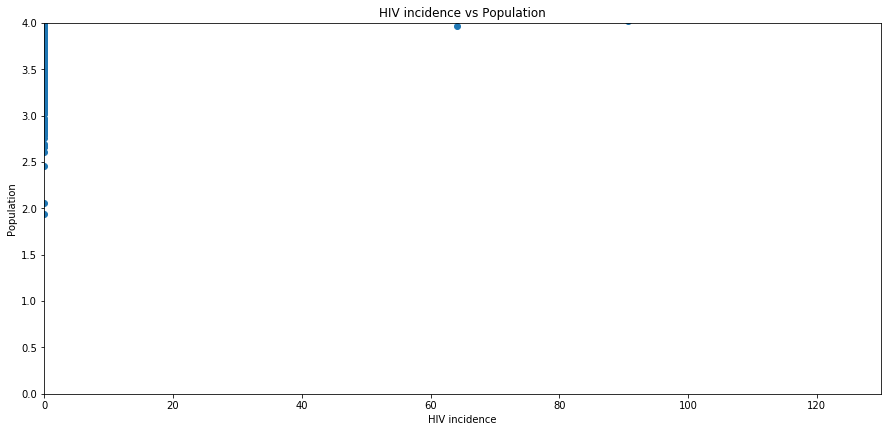

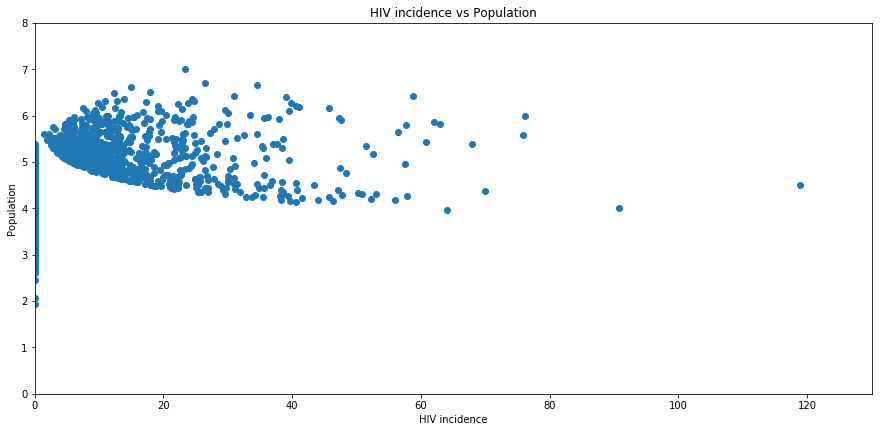

In [200]:
df_main['log10_population'] = np.log10(df_main.Population)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
ax1.scatter(df_main.HIVincidence, df_main.log10_population)
ax1.set_title('HIV incidence vs Population')
ax1.set_xlim(xmin=0, xmax=130)
ax1.set_ylim(ymin=0, ymax=4)
ax1.set_xlabel('HIV incidence')
ax1.set_ylabel('Population')

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(212)
ax1.scatter(df_main.HIVincidence, df_main.log10_population)
ax1.set_title('HIV incidence vs Population')
ax1.set_xlim(xmin=0, xmax=130)
ax1.set_ylim(ymin=0, ymax=8)
ax1.set_xlabel('HIV incidence')
ax1.set_ylabel('Population')

In [201]:
df_main_zeroInc.describe()

,HIVincidence,HIVprevalence,Population
count,2393.0,2393.000000,2393.000000
mean,0.0,94.940618,27450.484329
std,0.0,125.057595,29243.593721
min,0.0,0.000000,88.000000
25%,0.0,0.000000,8610.000000
50%,0.0,67.000000,17696.000000
75%,0.0,121.500000,35919.000000
max,0.0,1492.500000,243453.000000


In [209]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform

perc_black = df_main_no_zero_outlier.perc_black.values # predictor
HIV_incidence = df_main_no_zero_outlier.HIVincidence.values # target value

with Model() as pooled_model_perc_black:

    beta = Normal('beta', 0, sd=1e5, shape=2)
    sigma = HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*perc_black

    y = Normal('y', theta, sd=sigma, observed=HIV_incidence)

In [210]:
with pooled_model_perc_black:
    pooled_trace = sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:03<00:00, 655.32it/s]


In [211]:
b0, m0 = pooled_trace['beta'].mean(axis=0)
b0, m0

(5.9970036307834764, 0.55941181981517629)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2e9f8dd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2e32b6d8>]], dtype=object)

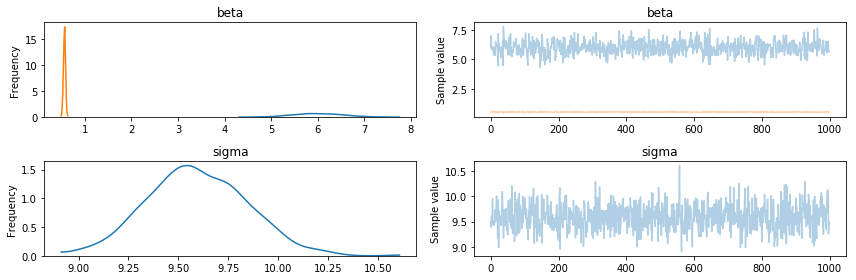

In [212]:
from pymc3 import traceplot  
traceplot(pooled_trace)

Text(0,0.5,'% of Population African American')

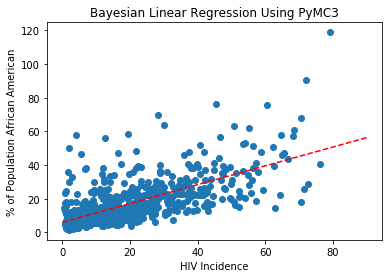

In [213]:
plt.scatter(perc_black, HIV_incidence)
xvals = np.linspace(0, 90)
plt.plot(xvals, m0*xvals+b0, 'r--');
plt.title('Bayesian Linear Regression Using PyMC3')
plt.xlabel('HIV Incidence')
plt.ylabel('% of Population African American')

In [214]:
HIV_incidence_pred = b0 + m0*perc_black
resid = HIV_incidence_pred - HIV_incidence
sum_resid_square = np.power(resid, 2).sum()
rmse = np.sqrt(sum_resid_square/len(perc_black))
print('Model RMSE is {}'.format(rmse))

Model RMSE is 9.567160982840049


In [217]:
from sklearn.preprocessing import StandardScaler

X = df_main_no_zero_outlier[['HIVprevalence', 
                             'perc_black', 
                             'pctunins', 
                             'log_household_income']].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

HIV_incidence = df_main_no_zero_outlier.HIVincidence.values # target value

with Model() as pooled_model_X:

    beta = Normal('beta', 0, sd=1e5, shape=X.shape[1]+1)
    sigma = HalfCauchy('sigma', 5)
    
    #theta = beta[0] + X.dot(beta.T[1:])
    theta = beta[0] + beta[1] * X[:,0] + beta[2] * X[:,1] + beta[3] * X[:,2] + beta[4] * X[:,3]
    y = Normal('y', theta, sd=sigma, observed=HIV_incidence)


In [218]:
with pooled_model_X:
    pooled_X_trace = sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:05<00:00, 355.66it/s]


In [220]:
b0, b1, b2, b3, b4 = pooled_X_trace['beta'].mean(axis=0)
b0, b1, b2, b3, b4

(15.99113329701982,
 6.5268698871982913,
 4.1620576710652726,
 2.3680601747012497,
 -1.7499382679214457)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2814cfd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c287aa358>]], dtype=object)

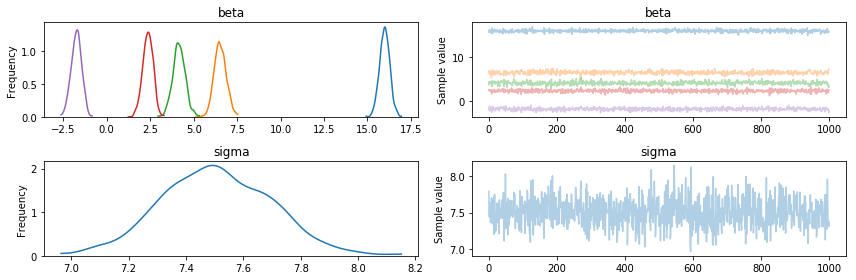

In [221]:
from pymc3 import traceplot  
traceplot(pooled_X_trace)

In [222]:
beta_arr = pooled_X_trace['beta'].mean(axis=0)
HIV_incidence_pred = beta_arr[0] + X.dot(beta_arr.T[1:])
resid = HIV_incidence_pred - HIV_incidence
sum_resid_square = np.power(resid, 2).sum()
rmse = np.sqrt(sum_resid_square/len(perc_black))
print('Model RMSE is {}'.format(rmse))

Model RMSE is 7.475442997446186


In [225]:
betas_df = pd.DataFrame(beta_arr.T, index=['intercept',
                                           'HIVprevalence', 
                             'perc_black', 
                             'pctunins', 
                             'log_household_income'])
betas_df

,0
intercept,15.991133
HIVprevalence,6.526870
perc_black,4.162058
pctunins,2.368060
log_household_income,-1.749938


In [226]:
from pymc3 import summary  
summary(pooled_X_trace) 


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  15.991           0.289            0.008            [15.359, 16.511]
  6.527            0.344            0.013            [5.869, 7.193]
  4.162            0.355            0.013            [3.409, 4.809]
  2.368            0.296            0.008            [1.771, 2.898]
  -1.750           0.295            0.009            [-2.311, -1.179]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  15.407         15.799         15.995         16.186         16.582
  5.875          6.292          6.516          6.756          7.221
  3.468          3.935          4.154          4.390          4.921
  1.778          2.178          2.374          2.583          2.915
  -2.341         -1.944         -1.744         -1.547         -1.196


sig

In [227]:
us_states = df_main_no_zero_outlier.STATEABBREVIATION.unique()
states = len(us_states)
state_lookup = dict(zip(us_states, range(len(us_states))))
state = df_main_no_zero_outlier['state_code'] = df_main_no_zero_outlier.STATEABBREVIATION.replace(state_lookup).values

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [229]:
with Model() as unpooled_model:

    intercept = Normal('beta0', 0, sd=1e5, shape=states)
    beta = Normal('beta1', 0, sd=1e5, shape=X.shape[1])
    sigma = HalfCauchy('sigma', 5)

    theta = intercept[state] + beta[0] * X[:,0] + beta[1] * X[:,1] + beta[2] * X[:,2] + beta[3] * X[:,3]
    y = Normal('y', theta, sd=sigma, observed=HIV_incidence)

In [230]:
with unpooled_model:
    unpooled_trace = sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [00:07<00:00, 272.02it/s]


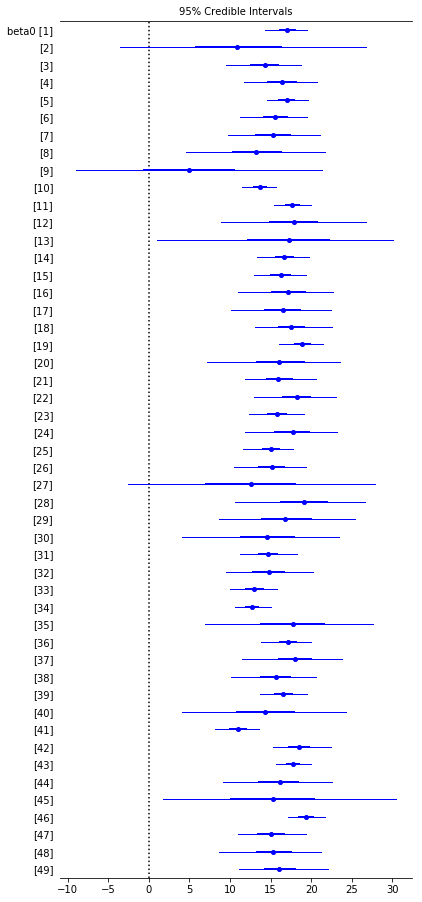

In [231]:
from pymc3 import forestplot

plt.figure(figsize=(6,14))
forestplot(unpooled_trace, varnames=['beta0']);

In [237]:
import pymc3
pooled_perc_black = pymc3.stats.waic(model=pooled_model_perc_black, trace=pooled_X_trace)
pooled = pymc3.stats.waic(model=pooled_model_X, trace=pooled_X_trace)
unpooled = pymc3.stats.waic(model=unpooled_model, trace=unpooled_trace)
pooled_model_perc_black

print(round(pooled_perc_black[0], 2), round(pooled_perc_black[1], 2))
print(round(pooled[0], 2), round(pooled[1], 2))
print(round(unpooled[0], 2), round(unpooled[1], 2))

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


3429761.37 366523.45
5143.47 109.03
5160.26 103.51


In [235]:
summary(unpooled_trace) 


beta0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  17.084           1.367            0.037            [14.323, 19.507]
  10.879           7.877            0.205            [-3.589, 26.728]
  14.270           2.392            0.056            [9.555, 18.791]
  16.373           2.417            0.054            [11.671, 20.693]
  16.970           1.329            0.037            [14.570, 19.628]
  15.588           2.092            0.055            [11.277, 19.456]
  15.363           2.973            0.073            [9.699, 21.120]
  13.225           4.393            0.097            [4.593, 21.707]
  4.880            7.934            0.214            [-8.939, 21.275]
  13.680           1.070            0.033            [11.506, 15.649]
  17.620           1.177            0.036            [15.437, 19.940]
  17.931           4.474            0.125            [8.851, 26.702]
  17.211    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24a22cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c24bc6d68>]], dtype=object)

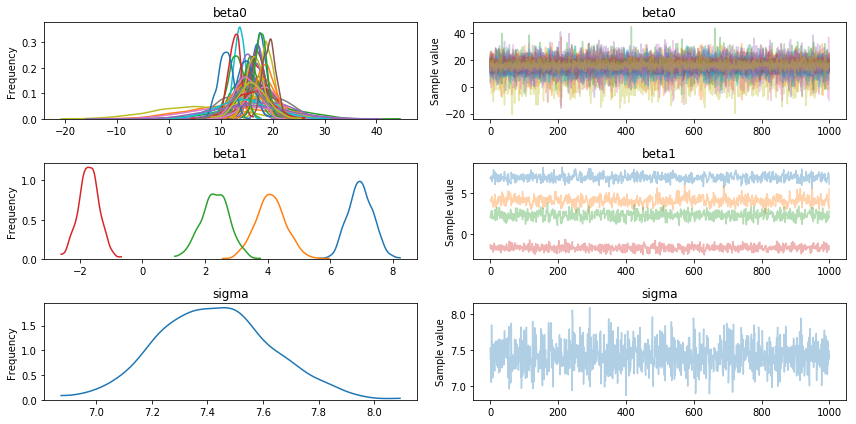

In [238]:
traceplot(unpooled_trace)

In [250]:
print(np.percentile(unpooled_trace['beta1'], 97.5, axis=0))
print(np.percentile(unpooled_trace['beta1'], 2.5, axis=0))

[ 7.70754471  5.07901439  3.20746492 -1.08610206]
[ 6.22503493  3.16285516  1.40398327 -2.33828948]


In [257]:
import pymc3
pooled_perc_black = pymc3.stats.waic(model=pooled_model_perc_black, trace=pooled_X_trace)
pooled = pymc3.stats.waic(model=pooled_model_X, trace=pooled_X_trace)
unpooled = pymc3.stats.waic(model=unpooled_model, trace=unpooled_trace)
pooled_model_perc_black

print(round(pooled_perc_black[0], 2), round(pooled_perc_black[1], 2))
print(round(pooled[0], 2), round(pooled[1], 2))
print(round(unpooled[0], 2), round(unpooled[1], 2))

/Users/elogue01/anaconda/envs/py3/lib/python3.6/site-packages/pymc3/stats.py:220: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


3429761.37 366523.45
5143.47 109.03
5160.26 103.51
